# Linear Regression with Polynomial Features

<IPython.core.display.Javascript object>


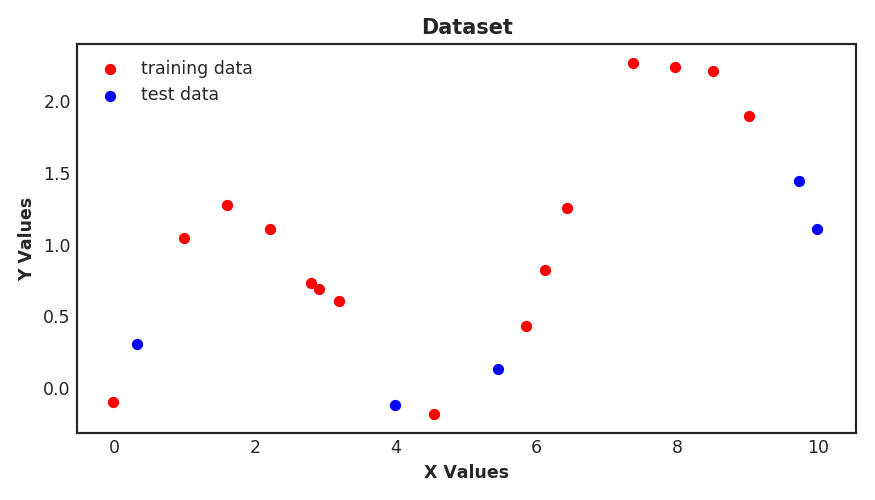

In [3]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def plt_scatter():
    plt.figure(figsize=(7, 4))
    plt.scatter(X_train, y_train, label='training data', c='red', s=30)
    plt.scatter(X_test, y_test, label='test data', c='blue', s=30)
    plt.legend(loc=2);
    plt.title('Dataset', weight='bold')
    plt.ylabel('Y Values', weight='bold')
    plt.xlabel('X Values', weight='bold')
    plt.tight_layout()
    
degrees = [1, 3, 6, 9]
n = 20
X = np.linspace(0, 10, n) + np.random.randn(n)/5
y = np.sin(X) + X/6 + np.random.randn(n)/10
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

plt.style.use('seaborn-white')
plt_scatter()

Fitting a polynomial LinearRegression model on the *training data* `X_train` for degrees 1, 3, 6, and 9 using PolynomialFeatures from sklearn.preprocessing. For each model, 100 values will be predicted over the interval x = 0 to 10.

<IPython.core.display.Javascript object>


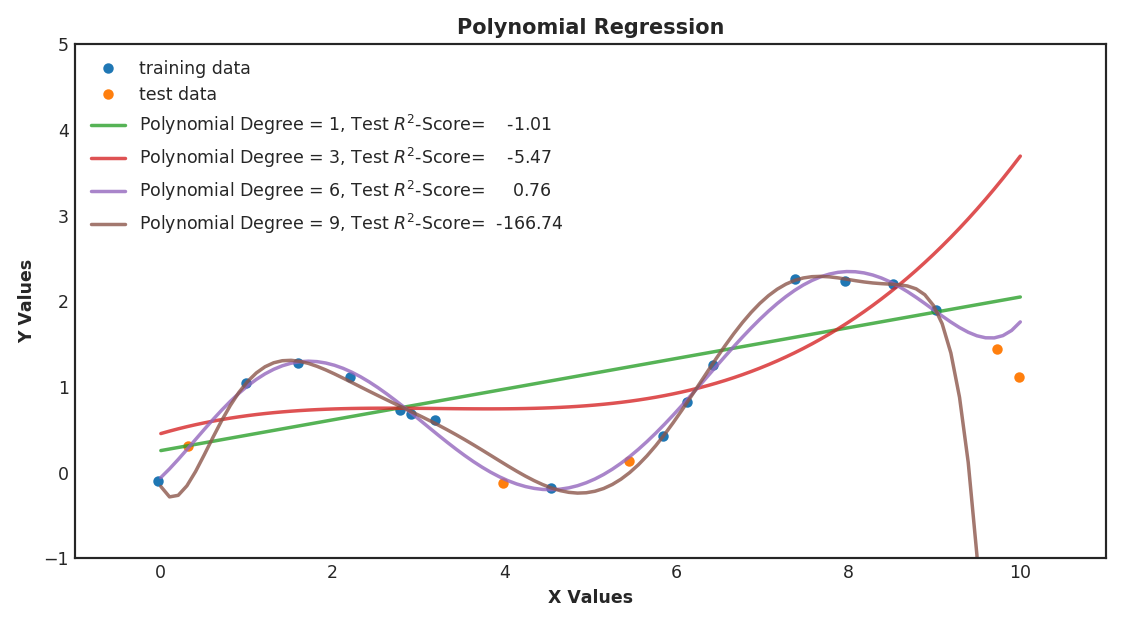

In [4]:
def polys():
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures

    results = []
    for i, deg in enumerate(degrees):
        poly = PolynomialFeatures(degree=deg)

        X_poly_train = poly.fit_transform(X_train.reshape(-1, 1))
        X_poly_test = poly.fit_transform(X_test.reshape(-1, 1))
        linreg = LinearRegression().fit(X_poly_train, y_train)

        X_predict = poly.transform(np.linspace(0,10,100).reshape(-1, 1))
        results.append([linreg.predict(X_predict), linreg.score(X_poly_test, y_test)])
        
    return results


def plot_polys(degree_predictions):
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.figure(figsize=(9,5))
    plt.plot(X_train, y_train, '.', label='training data', markersize=10)
    plt.plot(X_test, y_test, '.', label='test data', markersize=10)
    for i,degree in enumerate(degrees):
        plt.plot(np.linspace(0,10,100), degree_predictions[i][0], alpha=0.8, lw=2, 
                 label='Polynomial Degree = {}, Test $R^2$-Score={:9.2f}'.format(
                     degree, degree_predictions[i][1]))
    
    plt.title('Polynomial Regression', weight='bold')
    plt.ylabel('Y Values', weight='bold')
    plt.xlabel('X Values', weight='bold')
    plt.ylim(-1,5)
    plt.xlim(-1,11)
    plt.legend(loc=0)
    plt.tight_layout()

    
plot_polys(polys())